# Import Dependencies

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [53]:
import numpy as np
import pandas as pd
from scipy import stats

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

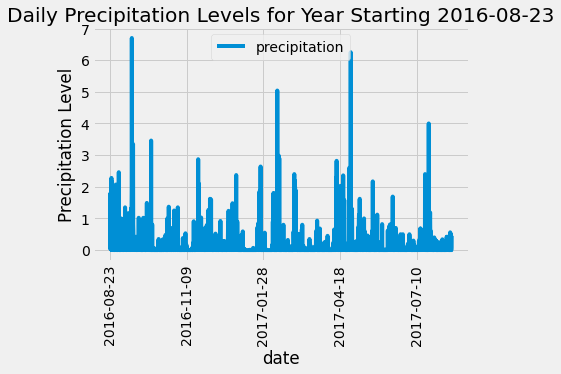

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

end_date = session.query(measurement.date).\
            order_by(measurement.date.desc()).first()

start_date = (dt.datetime.strptime(end_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
measurement_cols = (measurement.date, measurement.prcp)

precipitation = session.query(*measurement_cols).\
            filter(measurement.date >= start_date).all()

# # Save the query results as a Pandas DataFrame and set the index to the date column

weather_df = pd.DataFrame(precipitation,columns=['date','precipitation'])
weather_df.set_index('date', inplace=True)
weather_df = weather_df.sort_index()
weather_df =weather_df.fillna(0)
weather_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
ax = weather_df.plot(rot=90)
ax.set_title(f"Daily Precipitation Levels for Year Starting {start_date}")
ax.set_ylabel("Precipitation Level")
plt.savefig("Images/Daily_Precip_Level.png")

In [31]:
# Use Pandas to calcualte the summary statistics for the precipitation data
weather_df.describe()

,precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Station Analysis

In [33]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(station.id)).all()
stations

[(9)]

In [37]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(measurement.station, func.count(measurement.station)).\
                  group_by(measurement.station).\
                  order_by(func.count(measurement.station).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_temps = session.query(func.min(measurement.tobs),func.min(measurement.tobs), func.avg(measurement.tobs)).\
                filter(measurement.station == 'USC00519281').all()
station_temps
              

[(54.0, 54.0, 71.66378066378067)]

In [40]:
# Choose the station with the highest number of temperature observations.
USC00519281 =  session.query(measurement.date,measurement.tobs).\
                    filter(measurement.station == 'USC00519281').\
                    filter(measurement.date > last_year_date).all()
USC00519281[:5]

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0)]

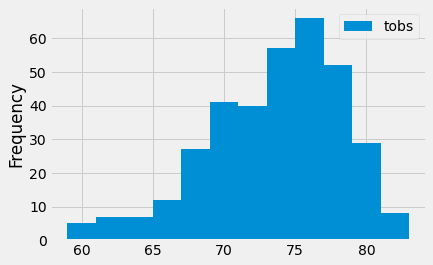

In [43]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

USC00519281= pd.DataFrame(USC00519281)
USC00519281.plot(kind="hist",bins=12);
plt.savefig("Images/USC00519281_Histogram_Temp_Observations.png")

# Bonus Climate App

In [ ]:
# Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.

# * Use Flask to create your routes.

In [ ]:
# ## Routes

# * `/`

#   * Home page.

#   * List all routes that are available.

# * `/api/v1.0/precipitation`

#   * Convert the query results to a dictionary using `date` as the key and `prcp` as the value.

#   * Return the JSON representation of your dictionary.

# * `/api/v1.0/stations`

#   * Return a JSON list of stations from the dataset.

# * `/api/v1.0/tobs`
#   * Query the dates and temperature observations of the most active station for the last year of data.
  
#   * Return a JSON list of temperature observations (TOBS) for the previous year.

# * `/api/v1.0/<start>` and `/api/v1.0/<start>/<end>`

#   * Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.

#   * When given the start only, calculate `TMIN`, `TAVG`, and `TMAX` for all dates greater than and equal to the start date.

#   * When given the start and the end date, calculate the `TMIN`, `TAVG`, and `TMAX` for dates between the start and end date inclusive.

# ## Hints

# * You will need to join the station and measurement tables for some of the queries.

# * Use Flask `jsonify` to convert your API data into a valid JSON response object.


# Bonus Tempurature Analysis I

In [ ]:
# * Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

# * You may either use SQLAlchemy or pandas's `read_csv()` to perform this portion.

# * Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

# * Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [49]:
# return data for June and December
june_data = session.query(measurement.date, measurement.tobs).filter(func.strftime("%m",measurement.date) == '06').all()
dec_data = session.query(measurement.date, measurement.tobs).filter(func.strftime("%m",measurement.date) == '12').all()

# Create Singluar data frame
june_df = pd.DataFrame(june_data,columns=["Date","Temperature"])
dec_df = pd.DataFrame(dec_data,columns=["Date","Temperature"])

#rename Columns
june_df["Month"] = "June"
dec_df["Month"] = "December"

#Comcat data
temp_df = pd.concat([june_df,dec_df], ignore_index=True)

# calculate the average for both June and December
avg_temp = temp_df.groupby("Month").mean()
avg_temp

,Temperature
Month,
December,71.041529
June,74.944118


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

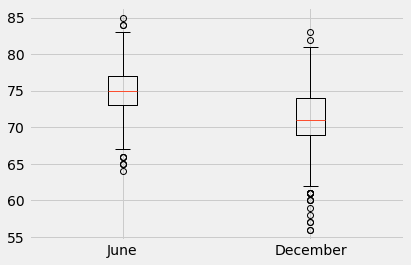

In [54]:
# * Use the t-test to determine whether the difference in the means, if any,
#is statistically significant. 
#Will you use a paired t-test, or an unpaired t-test? Why?

box_data = [june_df["Temperature"],dec_df["Temperature"]]
plt.boxplot(box_data,labels=['June', 'December']);
stats.ttest_ind(june_df["Temperature"], dec_df["Temperature"])

The plot indicates that there is a meaningful temperature 
difference between the months of June and Decmeber. 

Since the p-value is less than 0.05, (3.90) we can reject 
the null hypothesis thus conclude=ing that the difference 
in means is statistically significant.

# Bonus Tempurature Analysis II

In [61]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

In [100]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#set trip dates
trip_start = '2014-04-17'
trip_end = '2014-04-21'

#previous year calcs
last_start_date= (dt.datetime.strptime(trip_start,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
last_end_date= (dt.datetime.strptime(trip_end,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

vaca_temps = calc_temps(last_start_date,last_end_date)
vaca_temps

[(65.0, 72.8108108108108, 79.0)]

In [101]:
# create the dataframe
vaca_df = pd.DataFrame(vaca_temps, columns=['tmin', 'tavg', 'tmax'])

Text(0.5, 1.0, 'Trip Avg Temp')

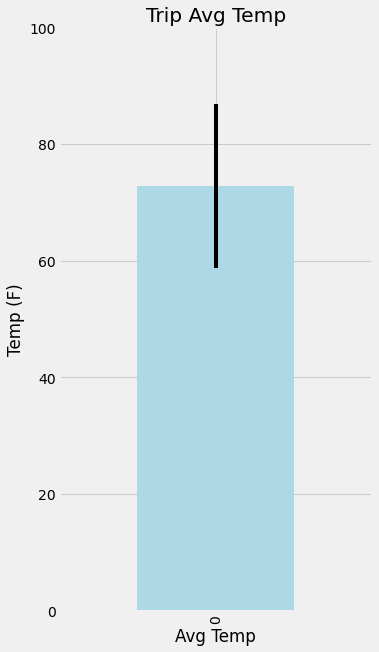

In [105]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(5,10))
ax=vaca_df["tavg"].plot.bar(yerr=(vaca_df["tmax"]-vaca_df["tmin"]), color="lightblue")
plt.ylim(0,100)
plt.xlabel("Avg Temp")
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")

# Rainfall Analysis

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = 4/17/2020
trip_end = 4/21/2020

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
